## Introduction
This notebook preprocesses the videos downloaded from 
[FaceForensics++ dataset](https://github.com/ondyari/FaceForensics).  To download the dataset, you have to fill a form on the Github Repo. Once filled, a python script is sent via email to download the dataset. [FaceForensics++ dataset](https://github.com/ondyari/FaceForensics) provides data in two formats, images and videos, and three qualities, raw, c23, and c40.  Raw videos are images are the highest quality where the videos and the images did not undergo any compression. (c23) videos are raw videos that underwent medium compression and (c40) videos underwent high compression (c40). Since there is a tradeoff between data size and data quality, I decided to work with the c23 videos. Note: I worked perviously with C40 videos for the first version of this project, but the video quality was very poor, making it easy to recognize manipulated videos. The downloaded dataset has the following structure.  

## Imports

In [52]:
#Directory Libraries
import sys, os
import glob
from os.path import join
#plotting libraries
import matplotlib.pylab as plt
from tqdm.notebook import tqdm
import seaborn as sns
#pre-processing 
from facenet_pytorch import MTCNN
from PIL import Image
import shutil
import cv2
import re
from PIL import Image
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import numpy as np
from numpy.random import seed
import pandas as pd
#parallel computing
from joblib import Parallel, delayed
import argparse
#Ignore unwanted warnings
import warnings
warnings.filterwarnings('ignore')
seed(101)
#Make sure that plots are colorblindfriendly
plt.style.use("seaborn-colorblind")


In [1]:
DATASET_PATHS = {
    'youtube': 'original_sequences/youtube/c23/',
    'actors': 'original_sequences/actors/c23/',
    'Deepfakes': 'manipulated_sequences/Deepfakes/c23/',
    'Face2Face': 'manipulated_sequences/Face2Face/c23/',
    'FaceShifter': 'manipulated_sequences/FaceShifter/c23/',
    'FaceSwap': 'manipulated_sequences/FaceSwap/c23/',
    'deepfakedetection': 'manipulated_sequences/DeepFakeDetection/'
}

## Extract the frames from the videos

In [11]:
#This code is adapted from https://github.com/ondyari/FaceForensics/blob/master/dataset/extract_compressed_videos.py 
data_path = "D:\\"
output_path = "D:\\"
def extract_frames(data_path, output_path):
    reader = cv2.VideoCapture(data_path)
    frame_num = 0
    while reader.isOpened():
        success, image = reader.read()
        if not success:
            break
        cv2.imwrite(join(output_path, '{:04d}.png'.format(frame_num)),
                        image)
        frame_num += 1
        reader.release()
    else:
        raise Exception('Wrong extract frames method: {}'.format(method))

def extract_method_videos(data_path, dataset, compression):
    videos_path = join(data_path, DATASET_PATHS[dataset], 'c23', 'videos')
    images_path = join(data_path, DATASET_PATHS[dataset], 'c23', 'images')
    for video in tqdm(os.listdir(videos_path)):
        image_folder = video.split('.')[0]
        extract_frames(join(videos_path, video),
                       join(images_path, image_folder))
for dataset in DATASET_PATHS.keys():
    extract_method_videos(data_path,DATASET_PATHS[dataset],'c23')


KeyError: 'original_sequences/youtube/c23/'

## Detect and Crop faces


In [ ]:
def f(folder,dataset):
    """
    f iterates through the image folders for each dataset, and it crops the face regions and        write the new images using open cv.

    :param folder (str): image folder name
    :param dataset (str): dataset name
    :return: None.
    """ 
    try:
        folder = str(folder)
        inter_path = 'D:\\'+ DATASET_PATHS[dataset] + 'images\\' + folder
        for image_ in os.listdir(inter_path):
            img = cv2.imread(os.path.join(inter_path,image_))
            frames = []
            if img is not None:
                frame = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                frames.append(Image.fromarray(frame))
                filename = image_.split('.')[0]
                if dataset == "youtube" or dataset == "actors": 
                    #move the cropped faces to either real or fake
                    #This is very important for making sure that
                    #the image generators are working correctly. 
                    output_path = "D:\\Base_directory\\Real\\"
                else:
                    output_path = "D:\\Base_directory\\Fake\\"
                #add the dataset_name in the path for further analysis
                save_paths = [output_path+f'{dataset}_{filename}{i}.jpg' for i in range(len(frames))]                        
                mtcnn(frames, save_path=save_paths)
    except Exception as e:
        print(e)

mtcnn = MTCNN(margin=20, keep_all=False)
folders_list = []
dataset_list = []
for dataset in DATASET_PATHS.keys():
    filenames = os.listdir('D:\\'+ DATASET_PATHS[dataset]+ 'images\\')
    for folder_ in filenames:
        # I added this line to ensure that all folder names were valid.
        if folder_ != '.DS_Store': 
            folders_list.append(folder_)
            dataset_list.append(dataset)
#I created the folders name list to see the progress bar            
pbar_i = tqdm(folders_list)
#run the function in Parallel to save time
print(Parallel(n_jobs=6)(delayed(f)(i,j) for i,j in zip(pbar_i,dataset_list)))

## Build the test and the training datasets

In [80]:
#compile a dictionary with the paths of each of the classes
Processed_datasets = {
    'Real': 'D:\\Base_directory\\Real\\',
    'Fake': 'D:\\Base_directory\\Fake\\'
}

In [79]:
def read_images(path):
    """
    read_images iterates through the preprocessed
    images and adds the labels for each image
    based on the directory of the image
    :param path (str): path for the preprocessed
    image
    :param dataset (str): dataset name
    :return: a Pandas dataframe with 
    image label and .
    """ 
    data = []
    filenames = glob.glob(Processed_datasets[path]+"\\*.jpg")
    pbar_i = tqdm(filenames)
    for image in pbar_i:
        frame_name = image.split("\\")[-1]
        dataset = frame_name.split("_")[0]
        if dataset!= "Face2Face":
            video_name = re.findall(r'\d+',image)[0]
        else:
            video_name = frame_name.split("_")[1].split(".")[0]
        if path == 'Real':
            label = 0
            data.append([video_name, label,frame_name,dataset])
        else: 
            label = 1
            data.append([video_name, label,frame_name,dataset])
    return data

In [47]:
# Run the function, and generate dataframes for both classes.
data_real = pd.DataFrame(read_images('Real'),columns=["Video_ID","Label","Frame_ID","Dataset"])
data_fake = pd.DataFrame(read_images('Fake'),columns=["Video_ID","Label","Frame_ID","Dataset"])
#Combine both datframes
frames = [data_real, data_fake]
df_data = shuffle(pd.concat(frames))

In [48]:
#take a look at the dataframe
df_data.head(5)

,Video_ID,Label,Frame_ID,Dataset
3405,02260,1,Deepfakes_02260_7.jpg,Deepfakes
11699,00450,1,Face2Face_00450_4.jpg,Face2Face
95,00000003100,0,actors_00000003100_2.jpg,actors
5431,15260,0,actors_15260_2.jpg,actors
12333,07080,0,youtube_07080_4.jpg,youtube


### Balance the Data

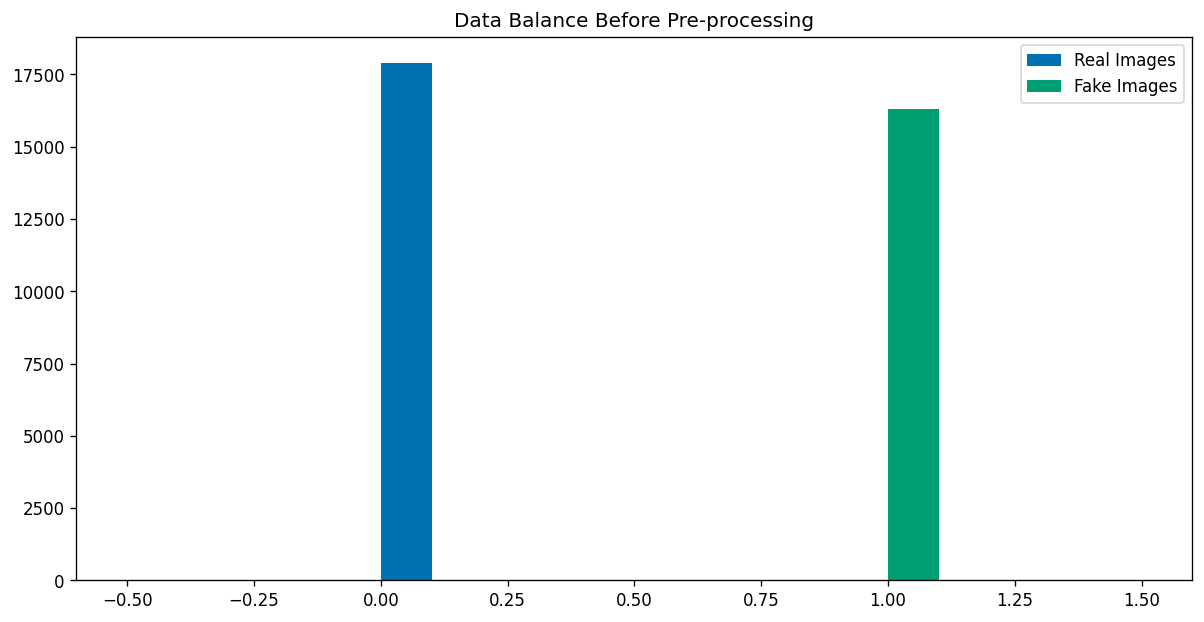

In [53]:
plt.figure(figsize=(12,6),dpi=120)
class_2 = np.ones(df_data['Label'].value_counts()[0])
class_1 = np.zeros(df_data['Label'].value_counts()[1])
plt.hist(class_1, label=["Real Images"])
plt.hist(class_2,label=["Fake Images"])
plt.title("Data Balance Before Pre-processing")
plt.legend()
plt.show()

In [57]:
#sample from both classes 
df_0 = df_data[df_data['Label'] == 0].sample(3000, random_state = 101)
df_1 = df_data[df_data['Label'] == 1].sample(3000, random_state = 101)
#connect the new samples to form an updated dataframe
df_data = pd.concat([df_0, df_1], axis=0).reset_index(drop=True)
# shuffle
df_data = shuffle(df_data)
#print to see if the data is balanced 
df_data['Label'].value_counts()

1    3000
0    3000
Name: Label, dtype: int64

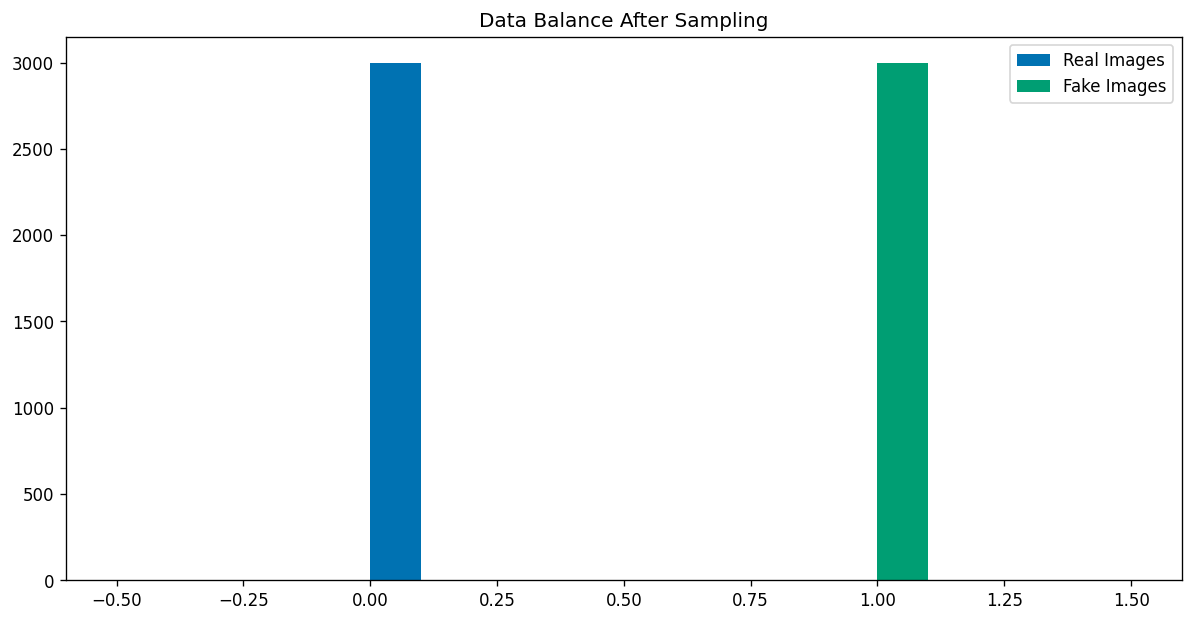

In [59]:
plt.figure(figsize=(12,6),dpi=120)
class_2 = np.ones(df_data['Label'].value_counts()[0])
class_1 = np.zeros(df_data['Label'].value_counts()[1])
plt.hist(class_1, label=["Real Images"])
plt.hist(class_2,label=["Fake Images"])
plt.title("Data Balance After Sampling")
plt.legend()
plt.show()

### Split the data into train and test

In [60]:
y = df_data['Label']

df_train, df_val = train_test_split(df_data, test_size=0.20, random_state=101, stratify=y)


### Create folders for the train and the test

In [72]:
base_dir = 'D:\\base__dir\\'
#train_dir
train_dir = os.path.join(base_dir, 'train_dir')
#create the dir
os.mkdir(train_dir)
# val_dir
val_dir = os.path.join(base_dir, 'val_dir')
#create the dir
os.mkdir(val_dir)
#Real images dir
original_os = os.path.join(train_dir, 'Real')
#create the dir
os.mkdir(original_os)
#Fake images dir
fake_os = os.path.join(train_dir, 'Fake')
#create the dir
os.mkdir(fake_os)
# create new folders inside val_dir
original_os = os.path.join(val_dir, 'Real')
#create the dir
os.mkdir(original_os)
fake_os = os.path.join(val_dir, 'Fake')
#create the dir
os.mkdir(fake_os)

In [ ]:
"""
📦base_dir
 ┣ 📂train_dir
 ┃ ┣ 📂Fake
 ┃ ┃ ┣ 📜Deepfakes_00070_2.jpg
 ┃ ┃ ┣ 📜Deepfakes_00110.jpg
 ┃ ┃ ┣ 📜Deepfakes_00120_2.jpg
 ┃ ┃ ┣ 📜....

 ┃ ┣ 📂Real
 ┃ ┃ ┣ 📜youtube_00080_2.jpg
 ┃ ┃ ┣ 📜youtube_00100.jpg
 ┃ ┃ ┣ 📜youtube_00130.jpg
 ┃ ┃ ┣ 📜....
 

 ┣ 📂val_dir
 ┃ ┣ 📂Fake
 ┃ ┃ ┣ 📜Deepfakes_00020.jpg
 ┃ ┃ ┣ 📜Deepfakes_00790.jpg
 ┃ ┃ ┣ 📜Deepfakes_01070.jpg
 ┃ ┃ ┣ 📜....

 ┃ ┣ 📂Real
 ┃ ┃ ┣ 📜youtube_00090_2.jpg
 ┃ ┃ ┣ 📜youtube_00480.jpg
 ┃ ┃ ┣ 📜youtube_00710_2.jpg
 ┃ ┃ ┣ 📜....
"""


## Transfer the images to their corresponding folders

In [73]:
#get a list of all of the images listed in the train and test
train_list = list(df_train['Frame_ID'])
val_list = list(df_val['Frame_ID'])

In [81]:
def build_train_datset(image):
    fname = image
    """
    build_train_datset uses the name of the images
    listed in the df_train[], and then transfer
    them to the new directories created.
    
    :image (str): name for the image
    :return: None.
    """ 
# get the label for a certain image
    target = df_data.loc[df_data['Frame_ID'] == fname]['Label']
    if target.any() == 0:
        src = os.path.join(Processed_datasets['Real'], fname)
        label = 'Real'
    else:
        src = os.path.join(Processed_datasets['Fake'],fname)
        label = 'Fake'
# destination path to image
    dst = os.path.join(train_dir, label,fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
#plot the progress
pbar = tqdm(train_list)
transfer_images = Parallel(n_jobs=4)(delayed(build_train_datset)(t) for t in pbar)


In [85]:
def build_test_datset(image):
    """
    build_test_datset uses the name of the images
    listed in the df_test[], and then transfer
    them to the new directories created.
    
    :image (str): name for the image
    :return: None.
    """
    fname = image
# get the label for a certain image
    target = df_data.loc[df_data['Frame_ID'] == fname]['Label']
    if target.any() == 0:
        src = os.path.join(Processed_datasets['Real'], fname)
        label = 'Real'
    else:
        src = os.path.join(Processed_datasets['Fake'],fname)
        label = 'Fake'
# destination path to image
    dst = os.path.join(val_dir,label, fname)
# copy the image from the source to the destination
    shutil.copyfile(src, dst) 
#plot the progress
pbar = tqdm(val_list)       
transfer_images = Parallel(n_jobs=4)(delayed(build_test_datset)(t) for t in pbar)

## Save the dataframe that contains the data used for training

In [86]:
df_train["Train"] = np.ones(len(df_train))
df_val["Train"] = np.zeros(len(df_val))
Processed_frames = [df_train, df_val]
df_data_used = pd.concat(Processed_frames)
#save the datat preprocessed as csv file
df_data_used.to_csv("data_csv.csv")
df_train.to_csv("train_data_csv.csv")
df_val.to_csv("val_data_csv.csv")

In [143]:
df_data_used.groupby(['Video_ID','Label','Dataset']).agg({'Frame_ID': ['count']})

Frame_ID
                            count
Video_ID Label Dataset           
00000    0     youtube          1
00010    0     youtube          1
00050    0     youtube          1
00130    0     youtube          1
         1     Deepfakes        1
...                           ...
07670    1     Deepfakes        2
07710    1     Deepfakes        1
07720    1     Deepfakes        1
07860    1     Deepfakes        1
07870    1     Deepfakes        1

[190 rows x 1 columns]